# Video object detection

## Import the libraries

In [ ]:
!pip install Pillow
!pip install opencv-python

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install youtube_dl==2020.12.7

In [4]:
import cv2 
import skimage
import numpy as np
from PIL import Image
import time
import youtube_dl
import matplotlib.pyplot as plt
from transformers.image_utils import ImageFeatureExtractionMixin
from tqdm import tqdm

## Get frames from video

In [6]:
def adjust_frame(frame, patch_size):
    def reduce_size_black_rows(frame, patch_size, upper_limit, lower_limit):
        """
        Performs in-place reduction of the size of the black rows
        """
        zeros_row = np.zeros(frame.shape[1:]).astype(int)
        indices = np.array([i for i in range(frame.shape[0]) if (frame[i,:,:] == zeros_row).all()])
        if len(indices) > 0:
            upper_indices = indices[indices <= lower_limit]
            lower_indices = indices[indices >= upper_limit]
            #print(f'The shape of the frame is {frame.shape}')
            #print(f'The shape of upper_indices is {upper_indices.shape}')
            #print(f'The shape of lower_indices is {lower_indices.shape}')
            # a border = patch_size/2 is left at the top and the bottom of the frame
            if upper_indices.shape[0] > 0:
                min_row_idx = max([upper_indices[len(upper_indices)-1] - int(patch_size/2),0])
            else:
                min_row_idx = 0
            if lower_indices.shape[0] > 0:
                max_row_idx = min([lower_indices[0] + int(patch_size/2),frame.shape[0]])
            else:
                max_row_idx = frame.shape[0]

            rows_idxs = np.zeros(frame.shape[0]).astype(bool)
            rows_idxs[min_row_idx:max_row_idx+1] = 1

            return frame[rows_idxs,:,:]
        return frame


    def add_black_columns(frame, patch_size):
        """
        Performs in-place black columns concatenation to frame
        """
        n_columns = int(patch_size/2)
        vertical_black_col = np.zeros((frame.shape[0],n_columns,3)).astype(int)
        frame = np.concatenate((frame,vertical_black_col), axis=1)
        frame = np.concatenate((vertical_black_col,frame), axis=1)
        return frame


    #frame = reduce_size_black_rows(frame, patch_size, upper_limit=430, lower_limit=50)
    frame = add_black_columns(frame, patch_size)
    return frame

In [7]:
def get_video_frames(video_url, resolution='480p', frame_per_second=5, patch_size=32):
  """
  Function to detect the specified object in each frame of the video
  @param: video_url is the link to the video to analyse
  @param: resolution is the resolution of the video to acquire
  @param: frame_per_second is the number of frame to analyse in a second
  @param: concat_x indicates the number of frames to concatenate in a row
  @param: concat_y indicates the number of frames to concatenate in a column
  """
  # Get the video
  ydl_opts = {}
  ydl=youtube_dl.YoutubeDL(ydl_opts)
  info_dict=ydl.extract_info(video_url, download=False)

  # Instanciate the list
  images_list = []

  # Check the resolution
  list_of_available_resolutions = ['240p', '360p', '480p', '720p']
  if resolution not in list_of_available_resolutions:
    resolution = list_of_available_resolutions[0]

  formats = info_dict.get('formats', None)
  print("Obtaining frames")
  for f_number, f in enumerate(formats):

    # If the resolution is 360p and if the format is webm (faster than mp4)
    if f.get('format_note', None) == resolution and f.get('ext', None) == 'webm' and f.get('filesize', None) != None:
      # Get the url
      url = f.get('url', None)

      # Define how many frames to skip between each analysis
      skip_frames = int(f['fps'] / frame_per_second)

      cap = cv2.VideoCapture(url)
      current_frame = 0
      t0 = time.time()
      # Till the end of the video
      while True:
        print(f'Computing frame number {len(images_list)}')
        # Get the frame
        ret, frame = cap.read()

        if not ret:
            print(f'Finished the video')
            break

        # Add columns to the frame to improve the quality of the detections
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = adjust_frame(frame, patch_size)

        # Save the shape of the frame
        frame_dimension = frame.shape

        # If save the frame
        # cv.imwrite(filename, frame)
        # Append the frame and the filename in the lists
        images_list.append(frame)

        # Skip some frames
        current_frame += skip_frames
        cap.set(1, current_frame)
        #if cv2.waitKey(30) & 0xFF == ord('q'):
         #   break
      print("Saved {} images with format {} and resolution {} in {:.4} seconds ({:.4} minutes)".format(len(images_list), f.get('ext', None), f.get('format_note',None), (time.time() - t0), (time.time() - t0) / 60 ))
      
      return images_list, frame_dimension

In [ ]:
frames, frame_dimension = get_video_frames(video_url='https://www.youtube.com/watch?v=kuvJRGrInPU', 
                                           resolution='360p', frame_per_second=2, patch_size=32)

In [9]:
def show_frames(images, row_dim=4, num_of_images=None):
  """
  Function to show all the frames in the list
  @params: images is the list of images
  @params: row_dim is the number of images to show in a row
  @param: num_of_images indicates how many images to show
  """
  if num_of_images == None or num_of_images <= 0 or num_of_images > len(images):
    num_of_images = len(images)

  fig, axs = plt.subplots(int(num_of_images / row_dim), row_dim, figsize=(20, len(images[0][0]) // (row_dim*10)))

  for i in range(num_of_images):
    axs[int(i/row_dim), i%row_dim].imshow(images[i])
    axs[int(i/row_dim), i%row_dim].set_title('Frame: {}'.format(i))

  plt.plot()

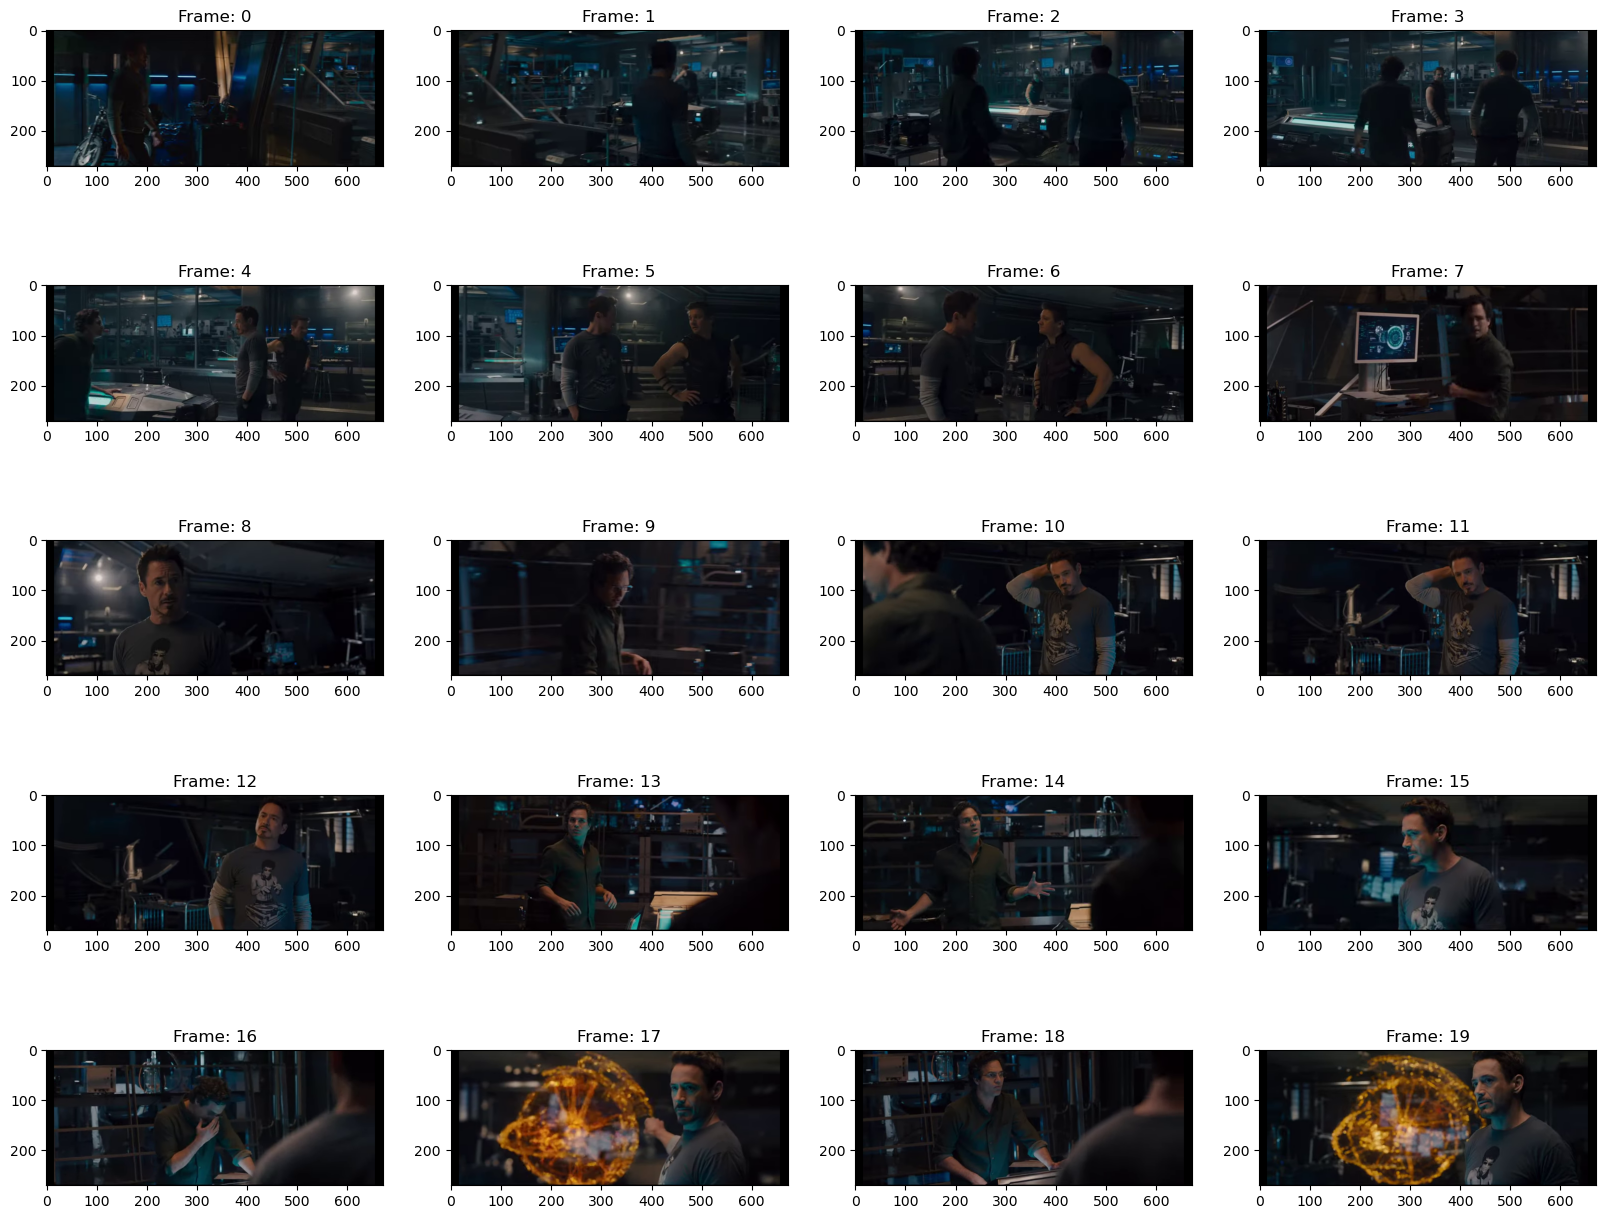

In [10]:
show_frames(frames[::5], 4, 20)

## Download the model

In [26]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

In [12]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Inference on video frames

In [13]:
# Nexted list of text queries to search each image for
text_queries = [["image of a gray t-shirt"] for _ in range(len(frames))]

# Process image and text inputs
inputs = processor(text=text_queries, images=np.array(frames), return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([275, 16])
attention_mask: torch.Size([275, 16])
pixel_values: torch.Size([275, 3, 768, 768])


In [14]:
time1 = time.time()

# model = model.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([(img.shape[0], img.shape[1]) for img in tqdm(frames)]).to(device)

# Convert outputs (bounding boxes and class logits) to COCO API
#results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

time2 = time.time()
print(f'elapsed time: {time2-time1}')

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")
        
print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

100%|██████████| 275/275 [00:00<00:00, 262322.86it/s]

elapsed time: 444.2657570838928
logits: shape of torch.Size([275, 576, 1])
pred_boxes: shape of torch.Size([275, 576, 4])
text_embeds: shape of torch.Size([275, 1, 512])
image_embeds: shape of torch.Size([275, 24, 24, 768])
class_embeds: shape of torch.Size([275, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([275, 16, 512])
pooler_output: shape of torch.Size([275, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([275, 577, 768])
pooler_output: shape of torch.Size([275, 768])


In [89]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      print(box)
      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

[0.42444715 0.64905757 0.22790268 0.6849423 ]


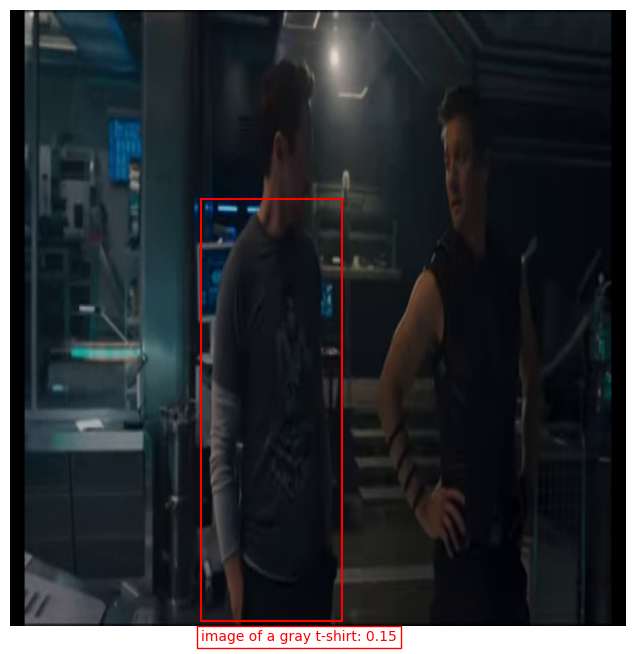

In [90]:
mixin = ImageFeatureExtractionMixin()

# Let's plot the predictions for the second image
image_idx = 25
image_size = model.config.vision_config.image_size
image = mixin.resize(frames[image_idx], image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.15

# Get prediction logits
logits = torch.max(outputs["logits"][image_idx], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][image_idx].cpu().detach().numpy()

plot_predictions(input_image, text_queries[image_idx], scores, boxes, labels)

## Import the model used for computing similarity between images 

In [17]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from transformers import AutoImageProcessor, DPTModel
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
# Load the models
image_processor = AutoImageProcessor.from_pretrained("Intel/dpt-large")
similarity_model = DPTModel.from_pretrained("Intel/dpt-large")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at Intel/dpt-large were not used when initializing DPTModel: ['neck.convs.3.weight', 'neck.reassemble_stage.layers.3.resize.weight', 'head.head.2.weight', 'neck.fusion_stage.layers.2.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.2.residual_layer2.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer2.convolution1.bias', 'neck.reassemble_stage.layers.2.projection.weight', 'neck.convs.1.weight', 'head.head.4.bias', 'neck.reassemble_stage.layers.0.projection.bias', 'neck.fusion_stage.layers.3.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.1.residual_layer2.convolution2.bias', 'neck.fusion_stage.layers.1.projection.bias', 'neck.reassemble_stage.readout_projects.1.0.weight', 'neck.fusion_stage.layers.1.residual_layer2.convolution1.weight', 'n

In [28]:
def get_image_encoding(image):
  # Process the input image
  inputs = image_processor(image, return_tensors="pt")

  with torch.no_grad():
      outputs = similarity_model(**inputs)

  # Get the ouput of the pooling layer
  image_encoding = outputs.pooler_output

  return image_encoding

def get_image(path):
  image = Image.open(path) 
  image = image.convert('RGB')
  return image

### Load the reference product for this video

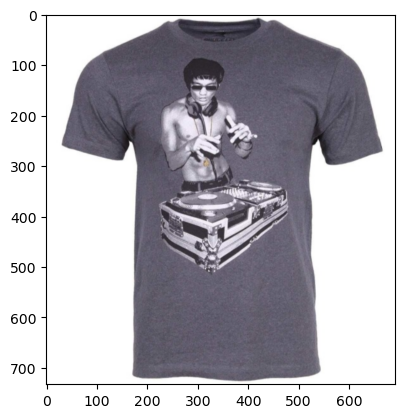

In [122]:
# Get the encoding of the reference image
reference_image = get_image("/kaggle/input/product-images/Product_images/DJ DRAGON CLASSIC HEATHER NAVY T-SHIRT.png")
reference_encoding = get_image_encoding(reference_image)

plt.imshow(reference_image)

## Collect all bounding boxes

In [195]:
bounding_boxes_list = []
# Threshold to eliminate low probability predictions
score_threshold = 0.15
# Threshold to eliminate the product non of interest according to their similarity wrt the reference item
similarity_threshold = 0.06

# These lists are just used for analyse the results
accepted_images = []
positive_scores = []
refused_images = []
negative_scores = []

for i in tqdm(range(len(frames))):
  
    frame_boxes = []

    # Get prediction logits
    logits = torch.max(outputs["logits"][i], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()

    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    boxes = outputs["pred_boxes"][i].cpu().detach().numpy()
    #boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    for score, box, label in zip(scores, boxes, labels):
        # If the model isn't sure enough, do not consider the bounding box
        if score < score_threshold:
            continue
        else:
            # Get the detected image coordinates
            cx, cy, w, h = box
            # Get the portion of the detected image 
            bb_image = frames[i][int(cy*frames[i].shape[0]-h*frames[i].shape[0]/2): int(cy*frames[i].shape[0]+h*frames[i].shape[0]/2), int(cx*frames[i].shape[1]-w*frames[i].shape[1]/2): int(cx*frames[i].shape[1]+w*frames[i].shape[1]/2)]
            # Get the encoding of the image
            bb_encoding = get_image_encoding(bb_image)
            # Compute the similarity score
            sim_score = cosine_similarity(reference_encoding, bb_encoding)[0][0]
            # If the score is higher than the thershold
            if sim_score >= similarity_threshold:
                accepted_images.append(bb_image)
                frame_boxes.append(box)
                positive_scores.append(sim_score)
            else:
                refused_images.append(bb_image)
                negative_scores.append(sim_score)
                
    bounding_boxes_list.append(frame_boxes)

In [196]:
bounding_boxes_list

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [array([0.42444715, 0.64905757, 0.22790268, 0.6849423 ], dtype=float32)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [array([0.3762481 , 0.75549704, 0.40121123, 0.48593053], dtype=float32)],
 [array([0.37619567, 0.7554707 , 0.3861062 , 0.48274735], dtype=float32)],
 [],
 [array([0.37402603, 0.7530522 , 0.3699403 , 0.49124157], dtype=float32)],
 [array([0.3773661 , 0.7515208 , 0.36838925, 0.49393648], dtype=float32)],
 [],
 [],
 [],
 [],
 [array([0.61989534, 0.67217827, 0.3261693 , 0.6514494 ], dtype=float32)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [array([0.6456449 , 0.671831  , 0.30780098, 0.6537066 ], dtype=float32)],
 [array([0.64226127, 0.676107  , 0.31431696, 0.6445161 ], dtype=float32)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [array([0.53187215, 0.6701344 , 0.3160025 , 0.65864843], dtype=float32)],
 [],
 [],
 [],
 [array([0

In [198]:
print(f'The number of accepted bb is {len(accepted_images)}')
print(f'The number of refused bb is  {len(refused_images)}')

The number of accepted bb is 35
The number of refused bb is  1


## Check the accepted and refused images and their scores

The score is 0.18097689747810364


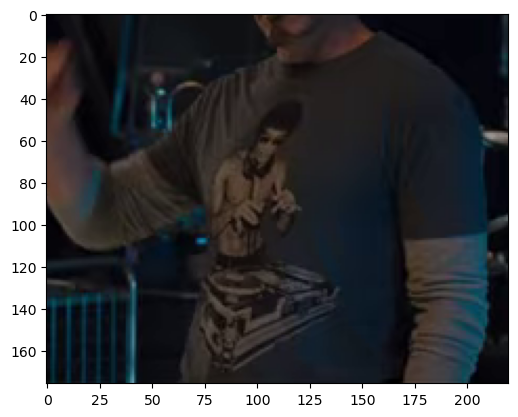

In [199]:
image_number = 5

print(f"The score is {positive_scores[image_number]}")
plt.imshow(accepted_images[image_number])

The score is 0.057648420333862305


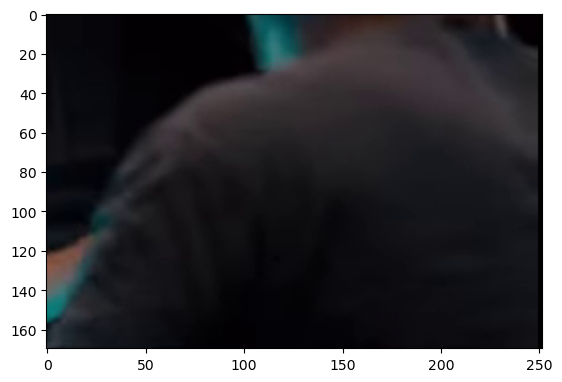

In [200]:
image_number = 0

print(f"The score is {negative_scores[image_number]}")
plt.imshow(refused_images[image_number])

## Build the dictionary

In [ ]:
info_dict = {}

info_dict['title'] = "Iron man vs Loki"
info_dict['sampling_rate'] = 2
info_dict['resolution'] = '360p'

# For each frame
for frame_number in tqdm(range(len(frames))):
  # Instanciate the info_dict dictionary for the current frame
  info_dict[frame_number] = {}
  # For each bounding box associated to the current frame
  for bb_index in range(len(bounding_boxes_list[frame_number])):
    # Get the current bounding box
    bb = bounding_boxes_list[frame_number][bb_index].tolist()
    # Extract the object image from the frame
    #bb_image = frames[frame_number][bb[1]: bb[1]+bb[3], bb[0]: bb[0]+bb[2]] 
    # If save the sub-image if it is valid
    #if bb_image.shape[0] > 0 and bb_image.shape[1] > 0:
    # Save the details into the dictionary
    info_dict[frame_number][bb_index] = {}
    info_dict[frame_number][bb_index]["Coordinates"] = bb


In [ ]:
info_dict

In [ ]:
#!rm -r /kaggle/working/ironman_vs_loki.json

In [ ]:
import json

with open("bruce_banners_tony_stark.json", "w") as outfile:
    json.dump(info_dict, outfile, indent=4)